In [2]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

simulator = AerSimulator()

simulator.configuration().to_dict()

{'backend_name': 'aer_simulator',
 'backend_version': '0.17.0',
 'n_qubits': 31,
 'basis_gates': ['ccx',
  'ccz',
  'cp',
  'crx',
  'cry',
  'crz',
  'cswap',
  'csx',
  'cu',
  'cu1',
  'cu2',
  'cu3',
  'cx',
  'cy',
  'cz',
  'diagonal',
  'ecr',
  'h',
  'id',
  'mcp',
  'mcphase',
  'mcr',
  'mcrx',
  'mcry',
  'mcrz',
  'mcswap',
  'mcsx',
  'mcu',
  'mcu1',
  'mcu2',
  'mcu3',
  'mcx',
  'mcx_gray',
  'mcy',
  'mcz',
  'multiplexer',
  'p',
  'pauli',
  'r',
  'roerror',
  'rx',
  'rxx',
  'ry',
  'ryy',
  'rz',
  'rzx',
  'rzz',
  's',
  'sdg',
  'store',
  'swap',
  'sx',
  'sxdg',
  't',
  'tdg',
  'u',
  'u1',
  'u2',
  'u3',
  'unitary',
  'x',
  'y',
  'z',
  'break_loop',
  'continue_loop',
  'delay',
  'for_loop',
  'if_else',
  'initialize',
  'kraus',
  'qerror_loc',
  'quantum_channel',
  'reset',
  'roerror',
  'save_amplitudes',
  'save_amplitudes_sq',
  'save_clifford',
  'save_density_matrix',
  'save_expval',
  'save_expval_var',
  'save_matrix_product_state',
 

The depth-optimized circuit for the SBOX has been found using the [DORCIS tool](https://eprint.iacr.org/2023/286). After that it has been rearranged to ensure that no mapping is needed on the input and output.

In [73]:
def sbox_circuit(input_bits: str | None = None):
    assert input_bits is None or len(input_bits) == 4

    circuit = QuantumCircuit(4)

    if input_bits:
        for qubit, value in enumerate(input_bits):
            if value == '1':
                circuit.x(3 - qubit)

    circuit.x(1)
    circuit.ccx(2,1,0)
    circuit.cx(1,2)
    circuit.cx(3,0)
    circuit.cx(0,1)
    circuit.x(0)
    circuit.ccx(3,2,1)
    circuit.ccx(1,0,3)
    circuit.x(1)
    circuit.cx(2,0)             
    circuit.ccx(3,1,2)          
    circuit.cx(2,1)             
    circuit.cx(0,3)             

    return circuit


Depth: 9


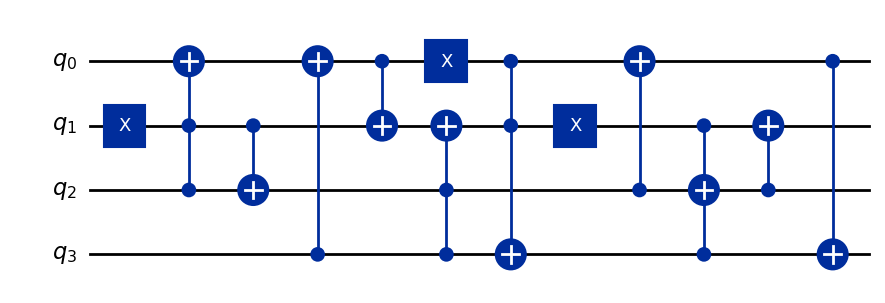

In [74]:
sbox = sbox_circuit()

print(f"Depth: {sbox.depth()}")

sbox.draw("mpl")


In [75]:
def test_sbox_circuit(input_bits: str | None = None):
    assert len(input_bits) == 4

    sbox = sbox_circuit(input_bits)

    sbox.measure_all()
    
    job = simulator.run(sbox, shots=1)
    result = job.result()
    counts = result.get_counts()

    output = list(counts)[0]

    return hex(int(output, 2))[2:].upper(), sbox

for input_number in range(0, 16):
    output, _ = test_sbox_circuit(format(input_number, "04b"))
    print(f"{hex(input_number)[2:].upper()} : {output}")

0 : E
1 : D
2 : B
3 : 0
4 : 2
5 : 1
6 : 4
7 : F
8 : 7
9 : A
A : 8
B : 5
C : 9
D : C
E : 3
F : 6


The lCounter layer consists of adding constants determined by the consecutive states of the LFSR. The LFSR state is added to the rightmost bits of the main state, and the same LFSR state in reverse is added to the leftmost bits of the main state. The LFSR is clocked every time its state is used in a round.

To implement this layers, we can precompute the LFSR states for each round and for each bit equal to 1 add an X gate to the corresponding register.

In [76]:
def lfsr_state(round: int, initial_state: str = '000101', taps: list = [4, 5]):
    """Default values are for SPONGENT-88"""
    state = list(map(int, initial_state))
    
    for _ in range(round):
        feedback_bit = 0
        for tap in taps:
            feedback_bit ^= state[len(initial_state) - 1 - tap]
        
        state =  state[1:] + [feedback_bit]
    
    return ''.join(map(str, state))

In [77]:
lfsr_state(45)

'111111'

In [78]:
def l_counter_circuit(round: int, width: int = 88):
    state = lfsr_state(round)
    
    l_counter = QuantumCircuit(width)

    for qubit, i in enumerate(state[::-1]):
        if i == '1':
            l_counter.x(qubit)
            l_counter.x(width - 1 - qubit)

    return l_counter

In [82]:
lfsr_state(0)

'000101'

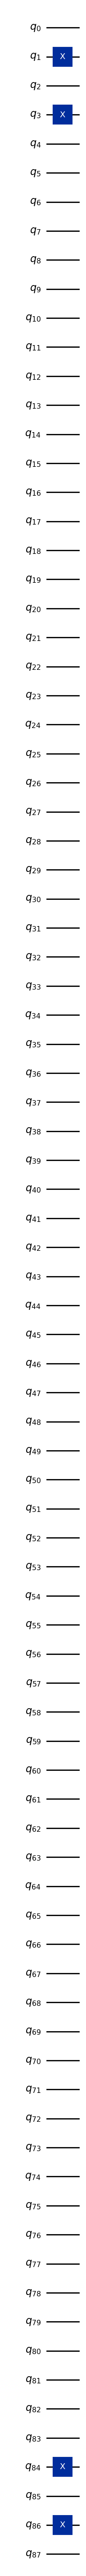

In [83]:
l_counter = l_counter_circuit(1)

l_counter.draw("mpl")

The permutation layer can be implemented as a simple qubit mapping according to the definition. This becomes a bit tricky doring the implementation.

In [80]:
def get_permuted_index(index: int, width: int):
    assert 0 <= index < width

    if 0 <= index <= width - 2:
        return int((index * width / 4) % (width - 1))
    else:
        return index

In [81]:
output_indexes = {}
for i in range(0, 88):
    output_indexes[i] = get_permuted_index(i, 88)
    print(f"{i} : {output_indexes[i]}")

0 : 0
1 : 22
2 : 44
3 : 66
4 : 1
5 : 23
6 : 45
7 : 67
8 : 2
9 : 24
10 : 46
11 : 68
12 : 3
13 : 25
14 : 47
15 : 69
16 : 4
17 : 26
18 : 48
19 : 70
20 : 5
21 : 27
22 : 49
23 : 71
24 : 6
25 : 28
26 : 50
27 : 72
28 : 7
29 : 29
30 : 51
31 : 73
32 : 8
33 : 30
34 : 52
35 : 74
36 : 9
37 : 31
38 : 53
39 : 75
40 : 10
41 : 32
42 : 54
43 : 76
44 : 11
45 : 33
46 : 55
47 : 77
48 : 12
49 : 34
50 : 56
51 : 78
52 : 13
53 : 35
54 : 57
55 : 79
56 : 14
57 : 36
58 : 58
59 : 80
60 : 15
61 : 37
62 : 59
63 : 81
64 : 16
65 : 38
66 : 60
67 : 82
68 : 17
69 : 39
70 : 61
71 : 83
72 : 18
73 : 40
74 : 62
75 : 84
76 : 19
77 : 41
78 : 63
79 : 85
80 : 20
81 : 42
82 : 64
83 : 86
84 : 21
85 : 43
86 : 65
87 : 87


The three layers above combined and repeated in R rounds create the full PI permutation. Now we need to use it as a foundation for the sponge construction.